In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn import preprocessing

import pickle
from google.colab import drive

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn.model_selection import train_test_split

In [2]:
# Mount the google drive to collab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/Cleaned Suicide Detection 2023-07-08.pkl'

df = pd.read_pickle(file_path)

In [4]:
df.head()

,text,class,text_cleaned,len_text,len_text_cleaned,pos_tags,chunk_chink
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,former wife threatening suicide recently left ...,715,378,"[(former, JJ), (wife, NN), (threatening, VBG),...","[[(former, JJ), (wife, NN)], [(threatening, VB..."
1,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliment coming someone k...,138,94,"[(weird, JJ), (get, NN), (affected, JJ), (comp...","[[(weird, JJ), (get, NN)], [(affected, JJ), (c..."
2,Finally 2020 is almost over... So I can never ...,non-suicide,silence bad year ever swear fucking god annoying,129,48,"[(finally, RB), (2020, CD), (almost, RB), (sil...","[(finally, RB), (2020, CD), (almost, RB), [(si..."
3,i need helpjust help me im crying so hard,suicide,need help help cry,41,18,"[(need, NN), (help, NN), (help, VB), (cry, VB)...","[[(need, NN)], [(help, NN)], [(help, VB)], [(c..."
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,ism lost hello name struggling year ism past y...,2426,1369,"[(ism, NN), (lost, VBD), (hello, JJ), (name, N...","[[(ism, NN)], [(lost, VBD)], [(hello, JJ), (na..."


# Original Dataset

# Cleaned Dataset V1

In [5]:
#Check for null values
df.isnull().sum()

text                0
class               0
text_cleaned        0
len_text            0
len_text_cleaned    0
pos_tags            0
chunk_chink         0
dtype: int64

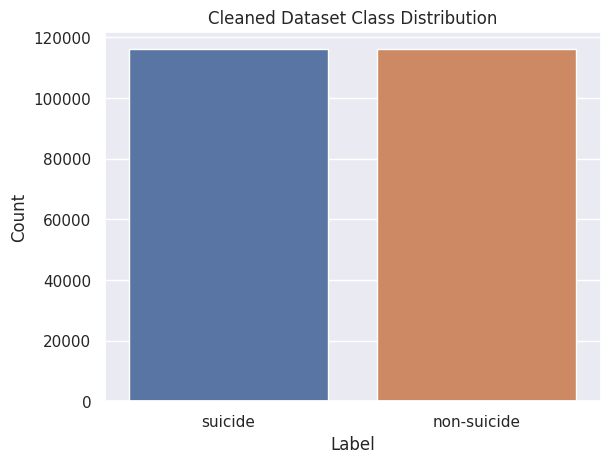

In [6]:
#Check dataset distribution by class
sns.countplot(x=df['class'])
plt.title('Cleaned Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

,len_text,len_text_cleaned
count,232073.000000,232073.000000
mean,131.925730,52.988202
std,217.477124,90.226019
min,1.000000,0.000000
25%,26.000000,12.000000
50%,60.000000,25.000000
75%,155.000000,61.000000
max,9684.000000,5850.000000


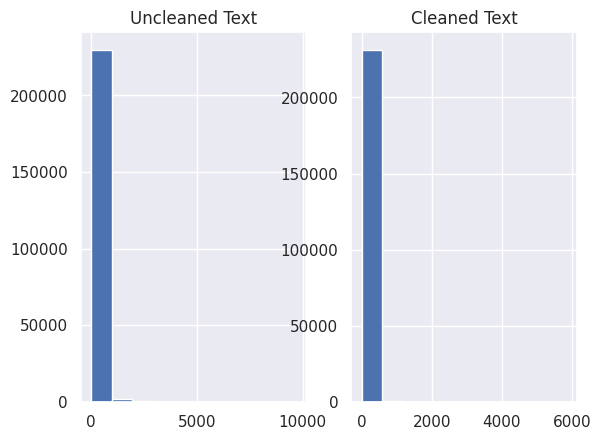

In [7]:
df['len_text_cleaned'] = [len(x.split()) for x in df['text_cleaned'].tolist()]
df['len_text'] = [len(x.split()) for x in df['text'].tolist()]

#Check text length by word count (uncleaned vs cleaned)
fig, axs = plt.subplots(1, 2)
axs[0].hist(df.len_text)
axs[0].set_title('Uncleaned Text')

axs[1].hist(df.len_text_cleaned)
axs[1].set_title('Cleaned Text')

## Too many outliers may skew dataset. Option #1: Remove outliers (<10%), Option #2: Normalize data. Recommendation: #1
df.describe()

##Triple confirm clean count may not be up to date


count    232073.000000
mean         52.988202
std          90.226019
min           0.000000
25%          12.000000
50%          25.000000
75%          61.000000
max        5850.000000
Name: len_text_cleaned, dtype: float64


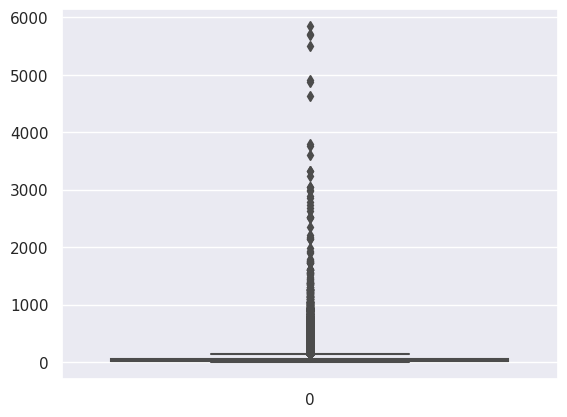

In [8]:
#Remove Outliers Part I - Visualize outliers
sns.boxplot(df['len_text_cleaned'])
print(df['len_text_cleaned'].describe())

In [9]:
#Remove Outliers
print("Old Shape: ", df.shape)

#IQR
Q1 = np.percentile(df['len_text_cleaned'], 25, method='midpoint')
Q3 = np.percentile(df['len_text_cleaned'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)

# Above Upper bound
upper=Q3+1.5*IQR
upper_array=np.array(df['len_text_cleaned']>=upper)
print("Upper Bound:",upper)
print(upper_array.sum())

#Below Lower bound
lower=Q1-1.5*IQR
lower_array=np.array(df['len_text_cleaned']<=lower)
print("Lower Bound:",lower)
print(lower_array.sum())

#Remove outliers
IndexUpperOutlier = df[(df['len_text_cleaned'] >= upper)].index
IndexLowerOutlier = df[(df['len_text_cleaned'] <= lower)].index
df.drop(index=IndexUpperOutlier, inplace=True)
df.drop(index=IndexLowerOutlier, inplace=True)
print("New Shape: ", df.shape)


Old Shape:  (232073, 7)
49.0
Upper Bound: 134.5
20530
Lower Bound: -61.5
0
New Shape:  (211543, 7)


In [10]:
df.head()

,text,class,text_cleaned,len_text,len_text_cleaned,pos_tags,chunk_chink
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,former wife threatening suicide recently left ...,143,57,"[(former, JJ), (wife, NN), (threatening, VBG),...","[[(former, JJ), (wife, NN)], [(threatening, VB..."
1,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliment coming someone k...,27,14,"[(weird, JJ), (get, NN), (affected, JJ), (comp...","[[(weird, JJ), (get, NN)], [(affected, JJ), (c..."
2,Finally 2020 is almost over... So I can never ...,non-suicide,silence bad year ever swear fucking god annoying,26,8,"[(finally, RB), (2020, CD), (almost, RB), (sil...","[(finally, RB), (2020, CD), (almost, RB), [(si..."
3,i need helpjust help me im crying so hard,suicide,need help help cry,9,4,"[(need, NN), (help, NN), (help, VB), (cry, VB)...","[[(need, NN)], [(help, NN)], [(help, VB)], [(c..."
5,Honetly idkI dont know what im even doing here...,suicide,honestly id done know even feel nothing nowher...,291,109,"[(honestly, RB), (id, VBZ), (done, VBN), (know...","[[(honestly, RB), (id, VBZ)], [(done, VBN)], [..."


count    211543.000000
mean         33.894192
std          30.632028
min           0.000000
25%          11.000000
50%          22.000000
75%          48.000000
max         134.000000
Name: len_text_cleaned, dtype: float64


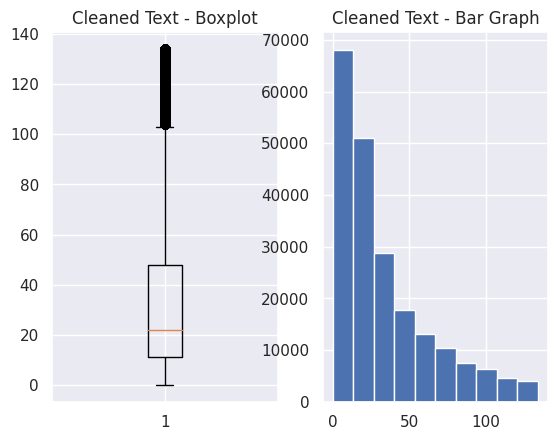

In [11]:
#Outliers Removed - Text Length Distribution

fig, axs = plt.subplots(1, 2)
axs[0].boxplot(df['len_text_cleaned'])
axs[0].set_title('Cleaned Text - Boxplot')

axs[1].hist(df.len_text_cleaned)
axs[1].set_title('Cleaned Text - Bar Graph')

print(df['len_text_cleaned'].describe())

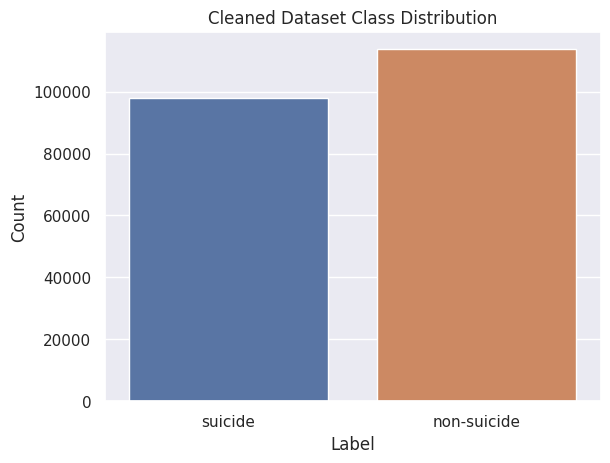

In [12]:
#Check dataset distribution by class (post removing outliers)
sns.countplot(x=df['class'])
plt.title('Cleaned Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Training Dataset

In [13]:
# Split dataset into train and test sets
train_data, test_data = train_test_split(df,test_size=0.2,random_state=42,stratify=df['class'])


# Split train set into classes
train_data_suicidal = train_data[train_data['class'] == "suicide"]
train_data_nonsuicidal = train_data[train_data['class'] == "non-suicide"]

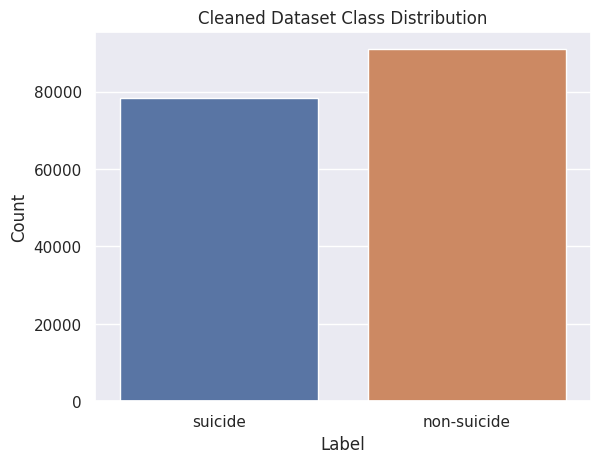

In [15]:
#Check dataset distribution by class
sns.countplot(x=train_data['class'])
plt.title('Cleaned Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Text Length by Class Comparison

In [ ]:
#Outliers Removed - Text Length Distribution by class

fig, axs = plt.subplots(1, 2)
axs[0].hist(train_data_suicidal.len_text_cleaned)
axs[0].set_title('Suicide Class')

axs[1].hist(train_data_nonsuicidal.len_text_cleaned)
axs[1].set_title('Non-Suicide Class')

print("Suicide Class: ", train_data_suicidal['len_text_cleaned'].describe())
print("Non-Suicide Class: ", train_data_nonsuicidal['len_text_cleaned'].describe())

Word Frequency by Class - Suicidal

In [16]:
#Word Frequency Part I
from keras.preprocessing.text import Tokenizer

tokenizer_suicidal = Tokenizer()
tokenizer_suicidal.fit_on_texts(train_data_suicidal["text_cleaned"])

In [17]:
#Word Frequency Part II
word_freq_suicidal = pd.DataFrame(tokenizer_suicidal.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_suicidal.head()

,word,count
13,want,72357
273,feel,56150
42,life,54696
100,know,51341
31,get,39215


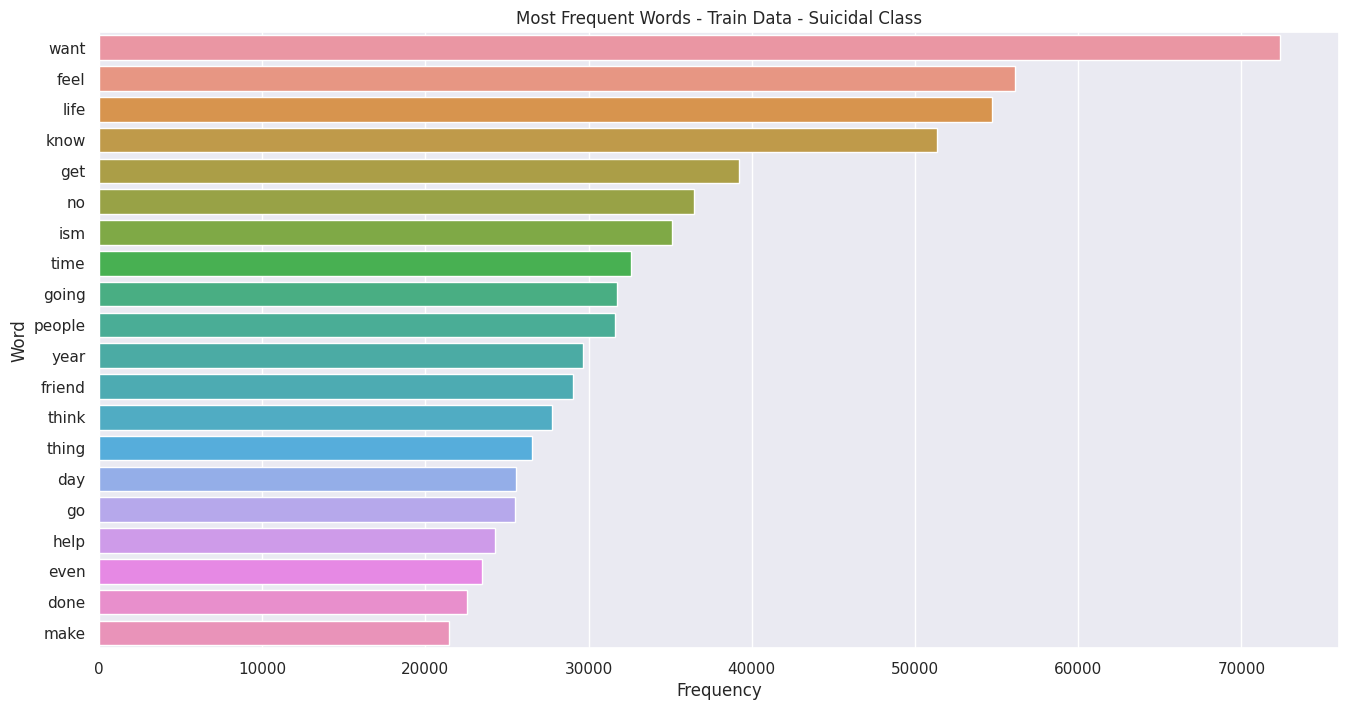

In [18]:
# Word Frequency Bar Graph - Top 20
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', data=word_freq_suicidal.iloc[:20])
plt.title('Most Frequent Words - Train Data - Suicidal Class')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

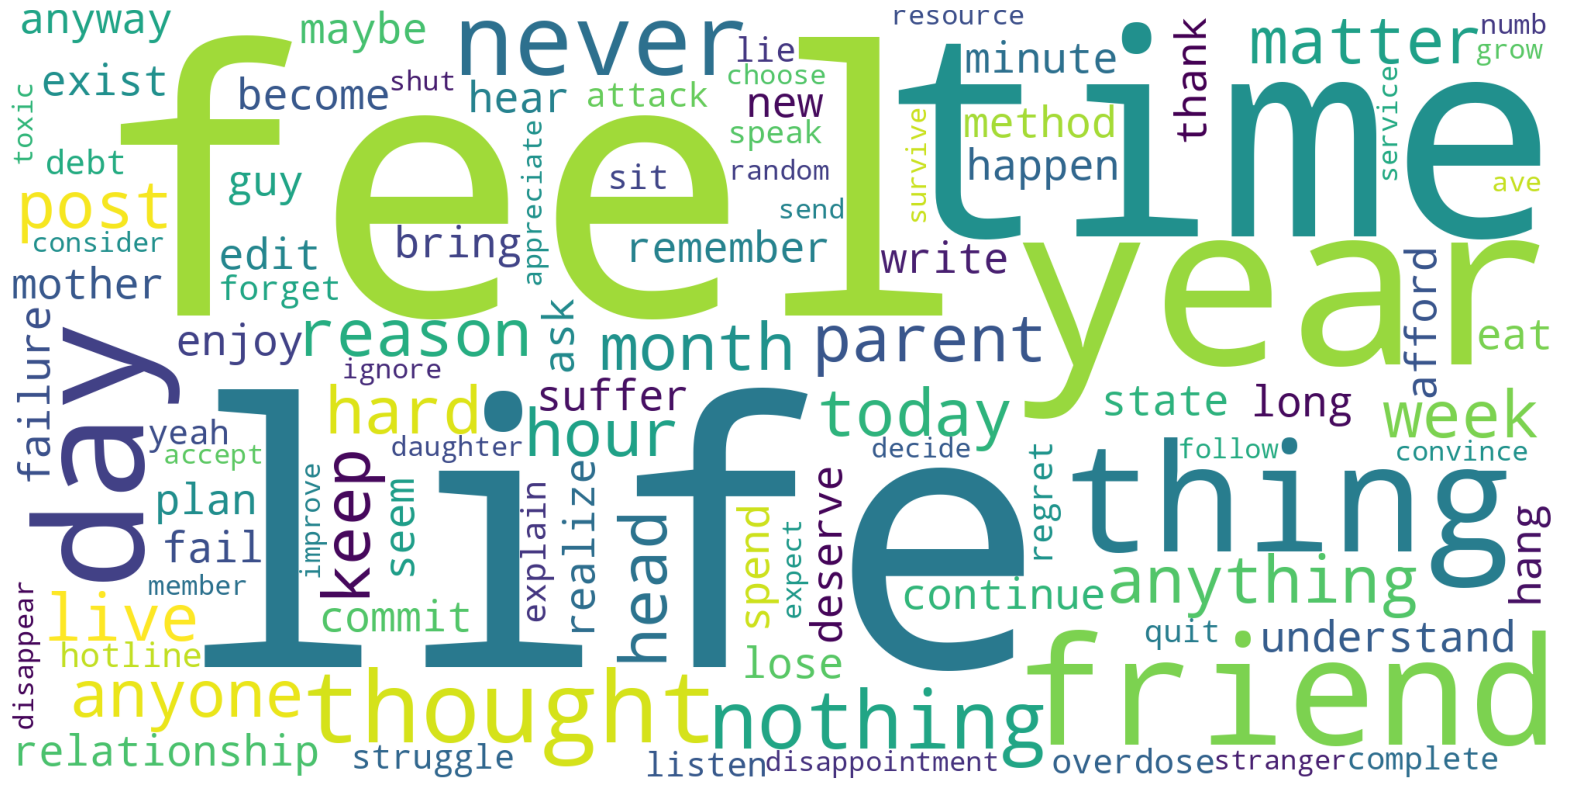

In [19]:
# Wordcloud
from wordcloud import WordCloud

feature_names = word_freq_suicidal['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

Word Frequency by Class - NonSuicidal

In [20]:
#Word Frequency Part I
from keras.preprocessing.text import Tokenizer

tokenizer_nonsuicidal = Tokenizer()
tokenizer_nonsuicidal.fit_on_texts(train_data_nonsuicidal["text_cleaned"])

In [21]:
#Word Frequency Part II
word_freq_nonsuicidal = pd.DataFrame(tokenizer_nonsuicidal.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_nonsuicidal.head()

,word,count
695,filler,25535
41,want,21699
30,know,20931
142,get,18369
34,ism,16529


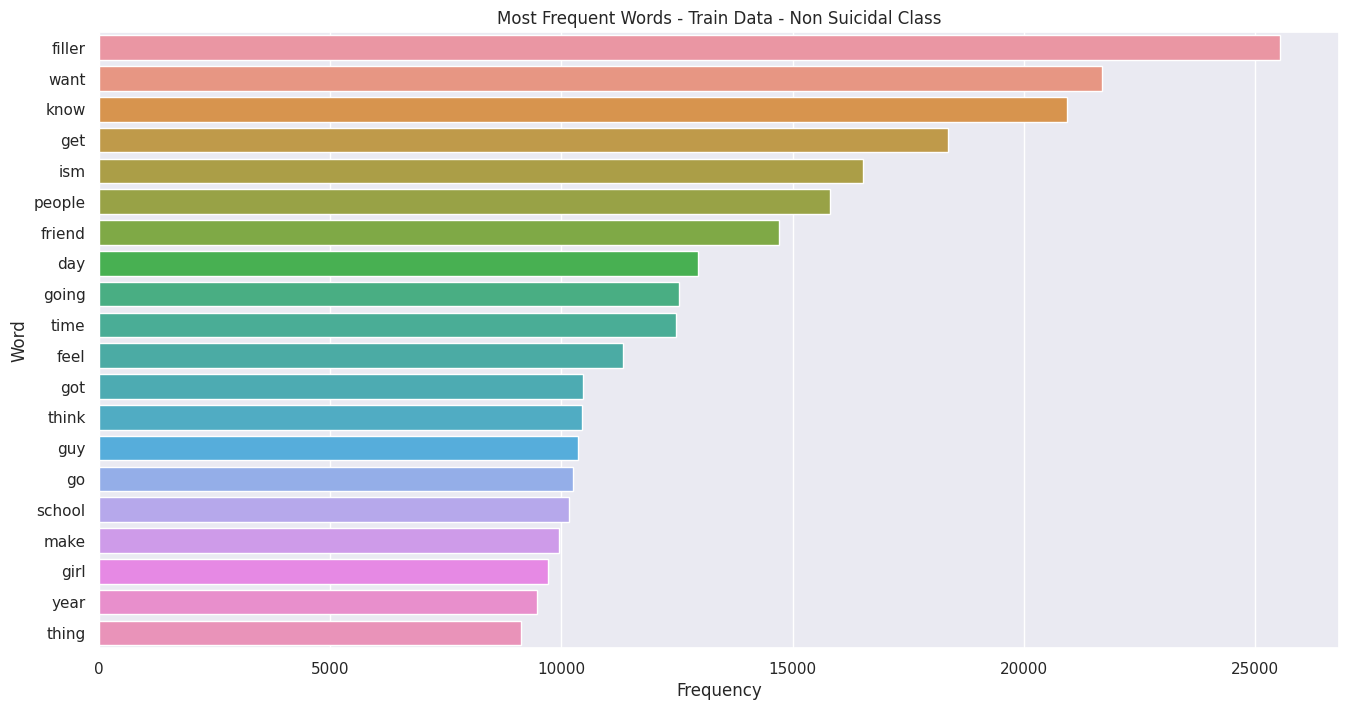

In [22]:
# Word Frequency Bar Graph - Top 20
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', data=word_freq_nonsuicidal.iloc[:20])
plt.title('Most Frequent Words - Train Data - Non Suicidal Class')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

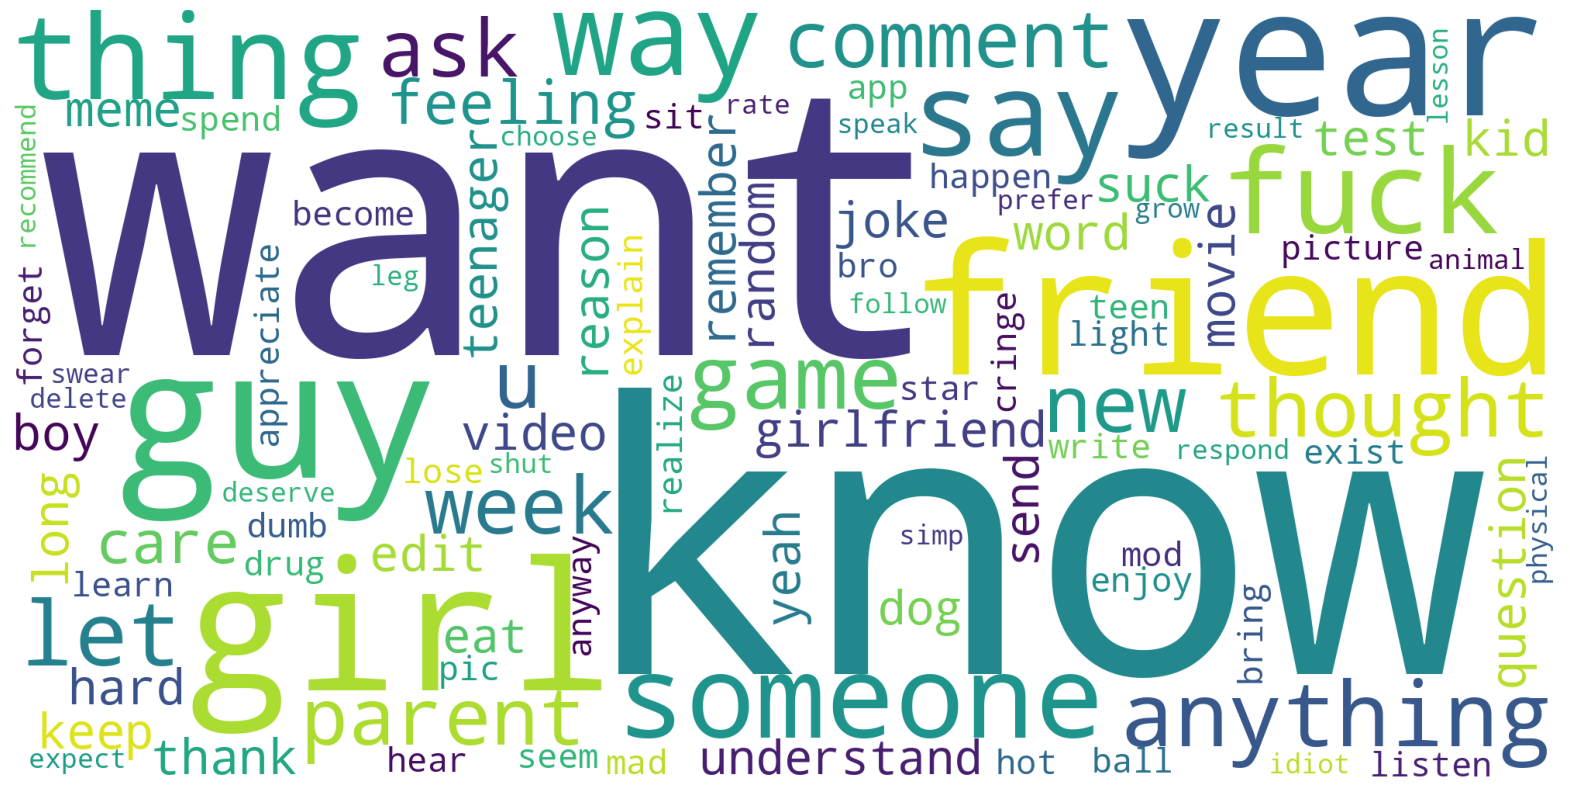

In [23]:
# Wordcloud
from wordcloud import WordCloud

feature_names = word_freq_nonsuicidal['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

Bigram Frequency

In [25]:
#Remove more stop words and do bigram
from nltk import bigrams
import itertools
import collections

#nonsuicidal
sentences_ns = [text.split() for text in train_data_nonsuicidal['text_cleaned']]

# Create list of lists containing bigrams in tweets
terms_bigram_ns = [list(bigrams(text)) for text in sentences_ns]

# Flatten list of bigrams in clean tweets
bigrams_ns = list(itertools.chain(*terms_bigram_ns))

# Create counter of words in clean bigrams
bigram_counts_ns = collections.Counter(bigrams_ns)

#Create a table of the top 20 most paired words
bigram_df_ns = pd.DataFrame(bigram_counts_ns.most_common(20),
                             columns=['Bigram', 'Count'])

print(bigram_df_ns)

                   Bigram  Count
0        (filler, filler)  22854
1    (transfer, protocol)   2992
2      (protocol, secure)   2989
3         (laugh, loudly)   2506
4         (andamp, x200b)   1829
5        (text, transfer)   1829
6          (anyone, want)   1753
7        (laughing, loud)   1576
8           (hyper, text)   1498
9            (min, craft)   1304
10           (ism, going)   1247
11           (want, talk)   1210
12           (need, help)   1171
13  (hypertext, transfer)   1163
14            (http, www)   1111
15             (eve, eve)   1085
16         (high, school)   1080
17            (year, old)   1075
18              (no, one)   1046
19            (sub, edit)    912


In [26]:
#suicidal
sentences_s = [text.split() for text in train_data_suicidal['text_cleaned']]

# Create list of lists containing bigrams in tweets
terms_bigram_s = [list(bigrams(text)) for text in sentences_s]

# Flatten list of bigrams in clean tweets
bigrams_s = list(itertools.chain(*terms_bigram_s))

# Create counter of words in clean bigrams
bigram_counts_s = collections.Counter(bigrams_s)

#Create a table of the top 20 most paired words
bigram_df_s = pd.DataFrame(bigram_counts_s.most_common(20),
                             columns=['Bigram', 'Count'])

print(bigram_df_s)

                 Bigram  Count
0           (want, die)   7818
1             (no, one)   7018
2       (laugh, loudly)   6659
3          (every, day)   3771
4          (want, kill)   3314
5           (want, end)   2926
6          (ism, going)   2700
7          (done, want)   2684
8          (done, know)   2583
9          (make, feel)   2508
10        (every, time)   2499
11  (suicidal, thought)   2419
12          (year, old)   2411
13       (high, school)   2330
14         (no, friend)   2283
15         (no, matter)   2237
16         (need, help)   2228
17         (even, know)   2228
18           (want, go)   2107
19       (really, want)   2106
